In [30]:
import practicalSPARQL
import pandas as pd
import ast
import matplotlib.pyplot as plt

In [31]:
root_q = 'queries'
root_d = 'results'

# read login data
login = pd.read_json('config_sparql.json')
ENDPOINT = login['endpoint'][0]
USERNAME = login['username'][0]
PASSWORD = login['password'][0]

# create sparql object
sparql = practicalSPARQL.practicalWrapper(ENDPOINT)
sparql.setCredentials(USERNAME, PASSWORD)

print("--- Querying ENDPOINT: {} ---".format(ENDPOINT))

--- Querying ENDPOINT: http://devmeta.sphaera.mpiwg-berlin.mpg.de/sparql ---


In [32]:
q = practicalSPARQL.stringify_SPARQL('elements_query_050824.sparql')    # select data from the ttl file as a dataframe
df = sparql.select_as_dataframe(q)

In [33]:
q = practicalSPARQL.stringify_SPARQL('books_query.sparql')    # select data from the ttl file as a dataframe
books = sparql.select_as_dataframe(q)

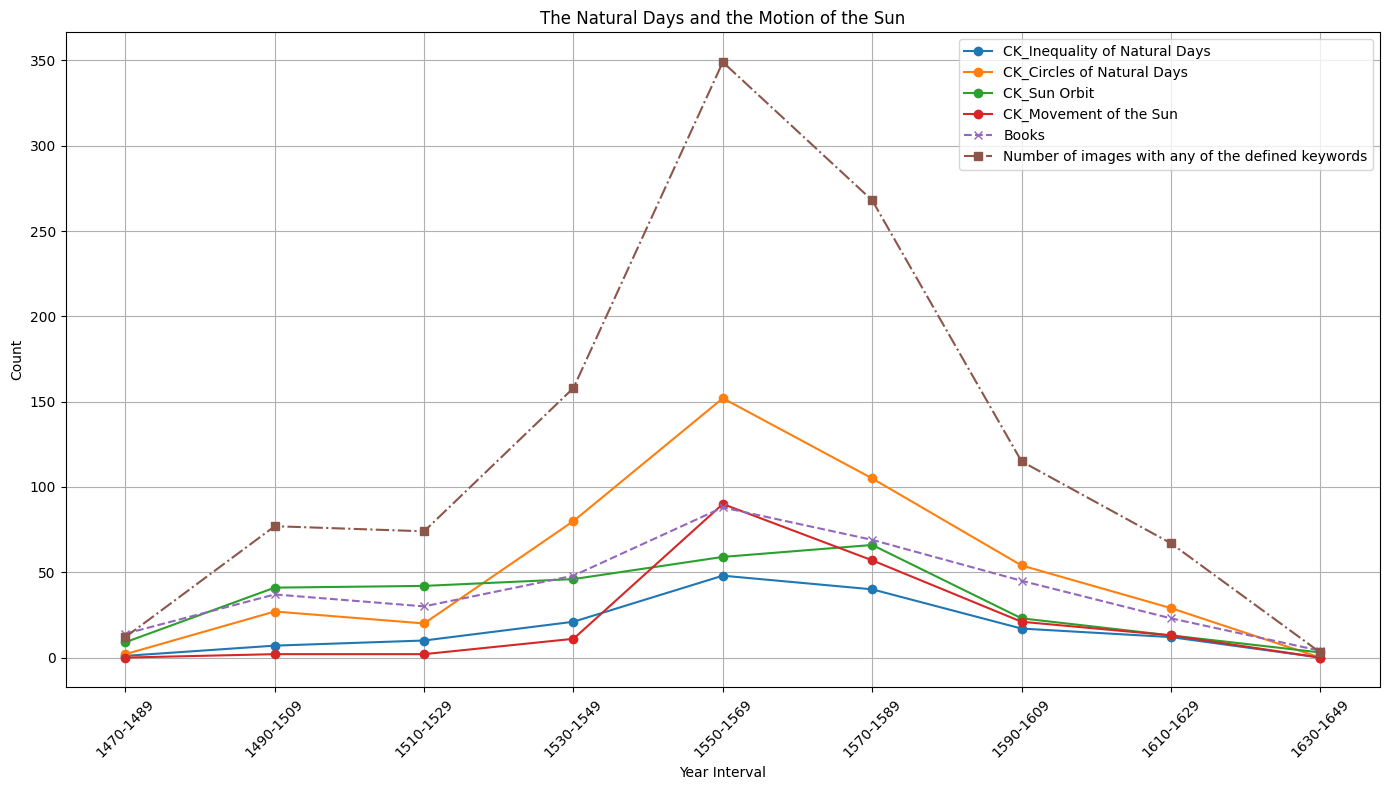

In [34]:
# Ensure the year column is of integer type
df['year'] = df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649'
]

# Add interval column to the DataFrames
df['interval'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Define keywords
keywords = [
    'CK_Inequality of Natural Days', 'CK_Circles of Natural Days', 
    'CK_Sun Orbit', 'CK_Movement of the Sun'
]

# Prepare a DataFrame for each keyword
keyword_dfs = {}
for keyword in keywords:
    mask = df['cks'] == keyword  # Exact match
    filtered_df = df[mask]
    unique_images_per_interval = filtered_df.groupby('interval', observed=False)['images'].nunique().reset_index()
    unique_images_per_interval.columns = ['interval', f'unique_images_{keyword}']
    keyword_dfs[keyword] = unique_images_per_interval

# Merge all keyword DataFrames on 'interval'
merged_keyword_df = keyword_dfs[keywords[0]]
for keyword in keywords[1:]:
    merged_keyword_df = pd.merge(merged_keyword_df, keyword_dfs[keyword], on='interval', how='outer')

# Count unique books per interval
unique_books_per_interval = books.groupby('interval', observed=False)['book'].nunique().reset_index()
unique_books_per_interval.columns = ['interval', 'unique_books']

# Merge the keyword DataFrame with the books DataFrame
final_df = pd.merge(merged_keyword_df, unique_books_per_interval, on='interval', how='outer')

# Calculate total unique images that have any of the keywords
mask_any_keyword = df['cks'].isin(keywords)  # Check if any keyword matches
unique_images_any_keyword = df[mask_any_keyword].groupby('interval', observed=False)['images'].nunique().reset_index()
unique_images_any_keyword.columns = ['interval', 'total_unique_images']

# Merge this into the final_df
final_df = pd.merge(final_df, unique_images_any_keyword, on='interval', how='outer')

# Plot the results
plt.figure(figsize=(14, 8))

# Plot each keyword
for keyword in keywords:
    plt.plot(final_df['interval'], final_df[f'unique_images_{keyword}'], label=f'{keyword}', marker='o')

# Plot unique books
plt.plot(final_df['interval'], final_df['unique_books'], label='Books', marker='x', linestyle='--')

# Plot total unique images
plt.plot(final_df['interval'], final_df['total_unique_images'], label='Number of images with any of the defined keywords', marker='s', linestyle='-.')

plt.xlabel('Year Interval')
plt.ylabel('Count')
plt.title('The Natural Days and the Motion of the Sun')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


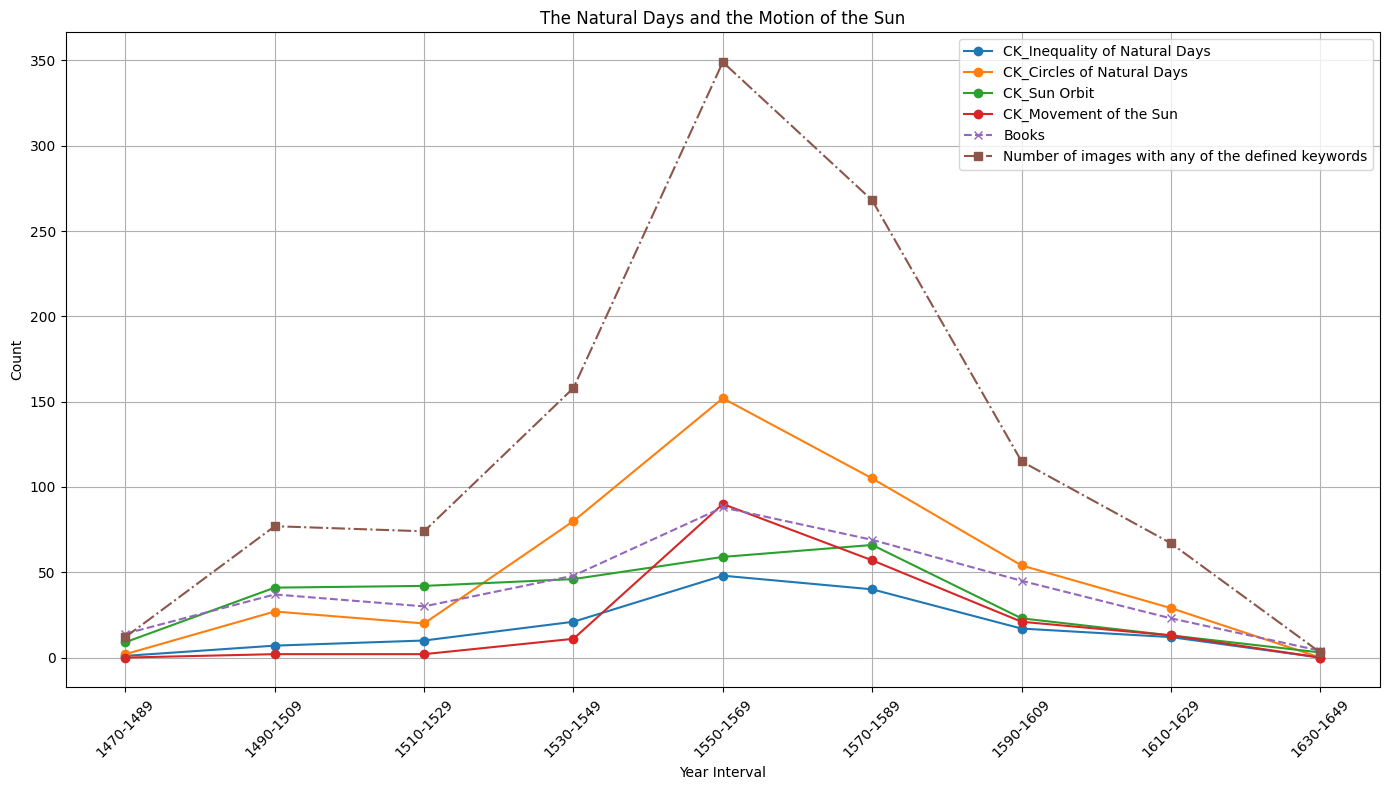

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the year column is of integer type
df['year'] = df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649'
]

# Add interval column to the DataFrames
df['interval'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Define keywords
keywords = [
    'CK_Inequality of Natural Days', 'CK_Circles of Natural Days', 
    'CK_Sun Orbit', 'CK_Movement of the Sun'
]

# Create a mask for filtering df based on keywords
mask_any_keyword = df['cks'].isin(keywords)  # Check if any keyword matches
filtered_df = df[mask_any_keyword]

# Prepare a DataFrame for each keyword
keyword_dfs = {}
for keyword in keywords:
    mask = filtered_df['cks'] == keyword  # Exact match
    unique_images_per_interval = filtered_df[mask].groupby('interval', observed=False)['images'].nunique().reset_index()
    unique_images_per_interval.columns = ['interval', f'unique_images_{keyword}']
    keyword_dfs[keyword] = unique_images_per_interval

# Merge all keyword DataFrames on 'interval'
merged_keyword_df = keyword_dfs[keywords[0]]
for keyword in keywords[1:]:
    merged_keyword_df = pd.merge(merged_keyword_df, keyword_dfs[keyword], on='interval', how='outer')

# Count unique books per interval
unique_books_per_interval = books.groupby('interval', observed=False)['book'].nunique().reset_index()
unique_books_per_interval.columns = ['interval', 'unique_books']

# Merge the keyword DataFrame with the books DataFrame
final_df = pd.merge(merged_keyword_df, unique_books_per_interval, on='interval', how='outer')

# Calculate total unique images that have any of the keywords
unique_images_any_keyword = filtered_df.groupby('interval', observed=False)['images'].nunique().reset_index()
unique_images_any_keyword.columns = ['interval', 'total_unique_images']

# Merge this into the final_df
final_df = pd.merge(final_df, unique_images_any_keyword, on='interval', how='outer')

# Plot the results
plt.figure(figsize=(14, 8))

# Plot each keyword
for keyword in keywords:
    if f'unique_images_{keyword}' in final_df.columns:
        plt.plot(final_df['interval'], final_df[f'unique_images_{keyword}'], label=f'{keyword}', marker='o')

# Plot unique books
plt.plot(final_df['interval'], final_df['unique_books'], label='Books', marker='x', linestyle='--')

# Plot total unique images
plt.plot(final_df['interval'], final_df['total_unique_images'], label='Number of images with any of the defined keywords', marker='s', linestyle='-.')

plt.xlabel('Year Interval')
plt.ylabel('Count')
plt.title('The Natural Days and the Motion of the Sun')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
# Define keywords
#keywords = [
#    'CK_Inequality of Natural Days', 'CK_Circles of Natural Days', 'CK_Sun Orbit', 'CK_Movement of the Sun'
#]

# Define a function to check if any keyword is in a string
#def contains_keywords(cks_value):
#    return any(keyword in cks_value for keyword in keywords)

# Create a boolean mask for the keywords
#mask = df['cks'].apply(contains_keywords)

# Filter the DataFrame based on the mask
#filtered_df = df[mask]

# Get the unique cluster_name values
#unique_cluster_names = filtered_df['cluster_name'].unique().tolist()

# Convert the list to a DataFrame
#unique_cluster_names_df = pd.DataFrame(unique_cluster_names, columns=['cluster_name'])

# Save the DataFrame to an Excel file
#output_file = 'natural_days_sun_motion.xlsx'
#unique_cluster_names_df.to_excel(output_file, index=False)


In [36]:
# Define the values to filter by
keywords = ['CK_Inequality of Natural Days', 'CK_Circles of Natural Days', 'CK_Sun Orbit', 'CK_Movement of the Sun']

# Create a boolean mask for filtering
mask = df['cks'].apply(lambda x: any(keyword in x for keyword in keywords))

# Filter the DataFrame
filtered_df = df[mask]

# Path to the Excel file
excel_file_path = 'C:\\Users\\nogas\\Image_data\\natural_days_sun_motion.xlsx'

# Load the Excel file into a DataFrame
excel_data = pd.read_excel(excel_file_path)

natural_days_sun_motion = pd.merge(filtered_df, excel_data, on='cluster_name', how='left')

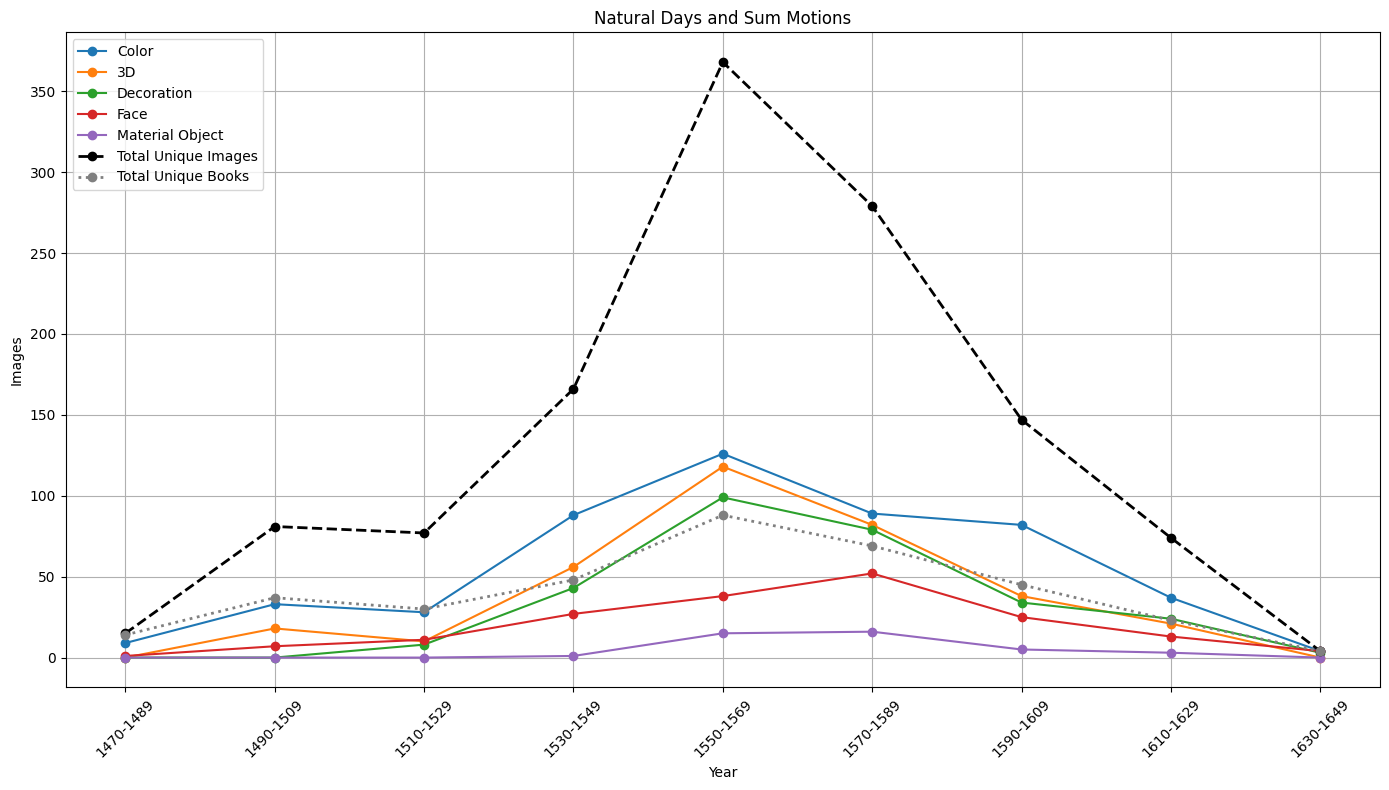

In [38]:
# Convert 'year' to int
natural_days_sun_motion['year'] = natural_days_sun_motion['year'].astype(int)
books['year'] = books['year'].astype(int)

# Create 20-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Create a new column for the 20-year intervals
natural_days_sun_motion['interval'] = pd.cut(natural_days_sun_motion['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Function to count unique images by column
def count_unique_images_by_column(column_name, value):
    filtered_df = natural_days_sun_motion[natural_days_sun_motion[column_name] == value]
    return filtered_df.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Collect data with updated column names
color = count_unique_images_by_column('color', 'yes')
three_dimensions_effect = count_unique_images_by_column('3D', 'yes')
decoration = count_unique_images_by_column('decoration', 'yes')
face = count_unique_images_by_column('face', 'yes')
multiple_moments = count_unique_images_by_column('multiple moments', 'yes')
sign_symbols = count_unique_images_by_column('sign symbols', 'yes')
numbers = count_unique_images_by_column('numbers', 'yes')
material_object = count_unique_images_by_column('material object', 'yes')
multiple_subjects_sun_and_moon = count_unique_images_by_column('multiple subjects sun and moon', 'yes')
tabular_illustration = count_unique_images_by_column('tabular illustration', 'yes')
human_figures = count_unique_images_by_column('human figures', 'yes')
oblique_circles = count_unique_images_by_column('oblique circles two dimensional projection', 'yes')

# Combine the data for lines
side_by_side_data = pd.DataFrame({
    'Color': color,
    '3D': three_dimensions_effect,
    'Decoration': decoration,
    'Face': face,
    # 'Multiple Moments': multiple_moments,
    # 'Sign Symbols': sign_symbols,
    # 'Numbers': numbers,
    'Material Object': material_object,
    # 'Multiple Subjects Sun and Moon': multiple_subjects_sun_and_moon,
    # 'Oblique Circles': oblique_circles,
})

# Calculate total unique books and images for each interval
total_unique_books_df = books.groupby('interval', observed=False)['book'].nunique().reindex(labels, fill_value=0)
total_unique_images = rising_setting_poets_visual.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Plot lines with single y-axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot lines for each category on primary y-axis
for column in side_by_side_data.columns:
    ax.plot(labels, side_by_side_data[column], marker='o', linestyle='-', label=column)

# Plot lines for total unique images and total unique books
ax.plot(labels, total_unique_images, marker='o', linestyle='--', color='black', label='Total Unique Images', linewidth=2)
ax.plot(labels, total_unique_books_df, marker='o', linestyle=':', color='gray', label='Total Unique Books', linewidth=2)

# Formatting the plot
ax.set_xlabel('Year')
ax.set_ylabel('Images')
ax.set_title('Natural Days and Sum Motions')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


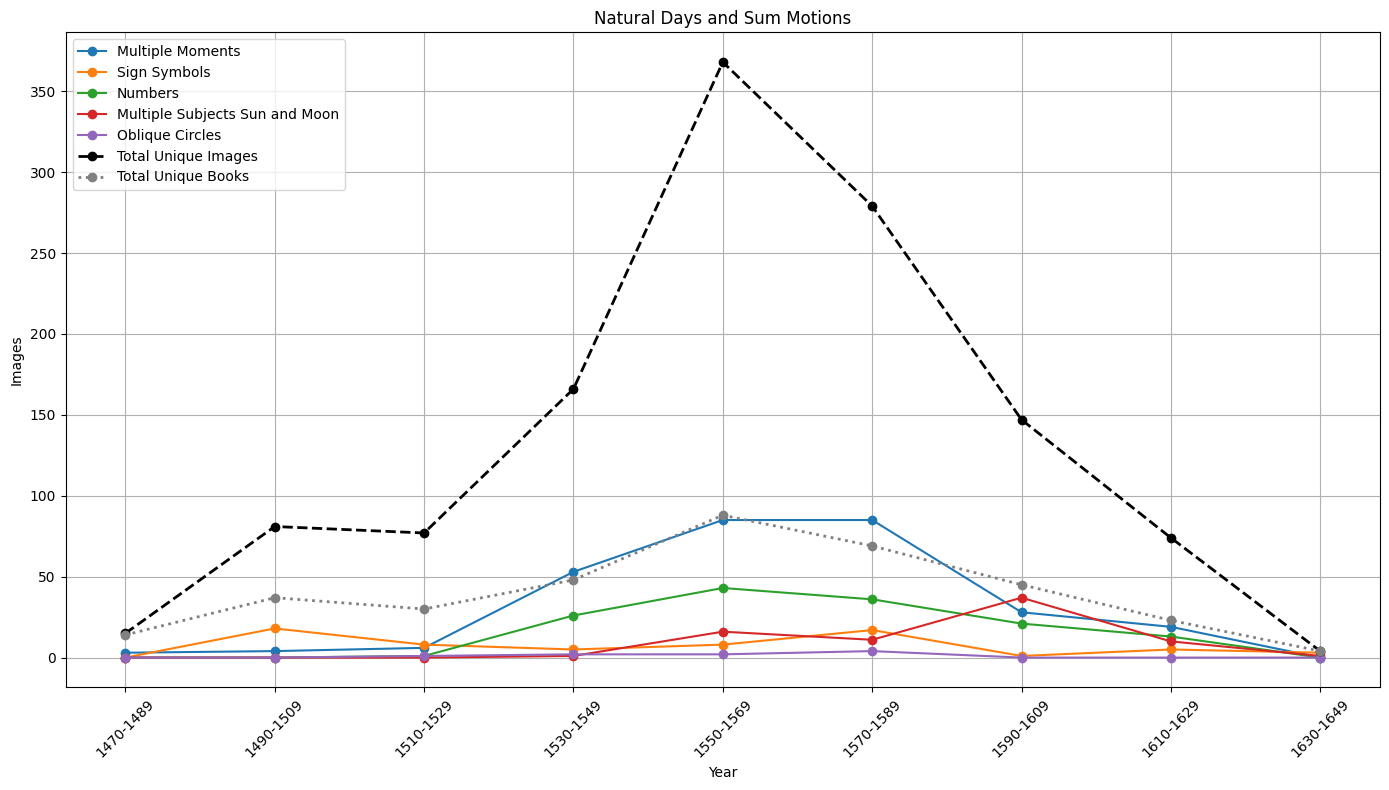

In [19]:
# Convert 'year' to int
rising_setting_poets_visual['year'] = rising_setting_poets_visual['year'].astype(int)
books['year'] = books['year'].astype(int)

# Create 20-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Create a new column for the 20-year intervals
rising_setting_poets_visual['interval'] = pd.cut(rising_setting_poets_visual['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Function to count unique images by column
def count_unique_images_by_column(column_name, value):
    filtered_df = rising_setting_poets_visual[rising_setting_poets_visual[column_name] == value]
    return filtered_df.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Collect data with updated column names
color = count_unique_images_by_column('color', 'yes')
three_dimensions_effect = count_unique_images_by_column('3D', 'yes')
decoration = count_unique_images_by_column('decoration', 'yes')
face = count_unique_images_by_column('face', 'yes')
multiple_moments = count_unique_images_by_column('multiple moments', 'yes')
sign_symbols = count_unique_images_by_column('sign symbols', 'yes')
numbers = count_unique_images_by_column('numbers', 'yes')
material_object = count_unique_images_by_column('material object', 'yes')
multiple_subjects_sun_and_moon = count_unique_images_by_column('multiple subjects sun and moon', 'yes')
tabular_illustration = count_unique_images_by_column('tabular illustration', 'yes')
human_figures = count_unique_images_by_column('human figures', 'yes')
oblique_circles = count_unique_images_by_column('oblique circles two dimensional projection', 'yes')

# Combine the data for lines
side_by_side_data = pd.DataFrame({
    # 'Color': color,
    # '3D': three_dimensions_effect,
    # 'Decoration': decoration,
    # 'Face': face,
    'Multiple Moments': multiple_moments,
    'Sign Symbols': sign_symbols,
    'Numbers': numbers,
    # 'Material Object': material_object,
    'Multiple Subjects Sun and Moon': multiple_subjects_sun_and_moon,
    'Oblique Circles': oblique_circles,
})

# Calculate total unique books and images for each interval
total_unique_books_df = books.groupby('interval', observed=False)['book'].nunique().reindex(labels, fill_value=0)
total_unique_images = rising_setting_poets_visual.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Plot lines with single y-axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot lines for each category on primary y-axis
for column in side_by_side_data.columns:
    ax.plot(labels, side_by_side_data[column], marker='o', linestyle='-', label=column)

# Plot lines for total unique images and total unique books
ax.plot(labels, total_unique_images, marker='o', linestyle='--', color='black', label='Total Unique Images', linewidth=2)
ax.plot(labels, total_unique_books_df, marker='o', linestyle=':', color='gray', label='Total Unique Books', linewidth=2)

# Formatting the plot
ax.set_xlabel('Year')
ax.set_ylabel('Images')
ax.set_title('Natural Days and Sum Motions')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


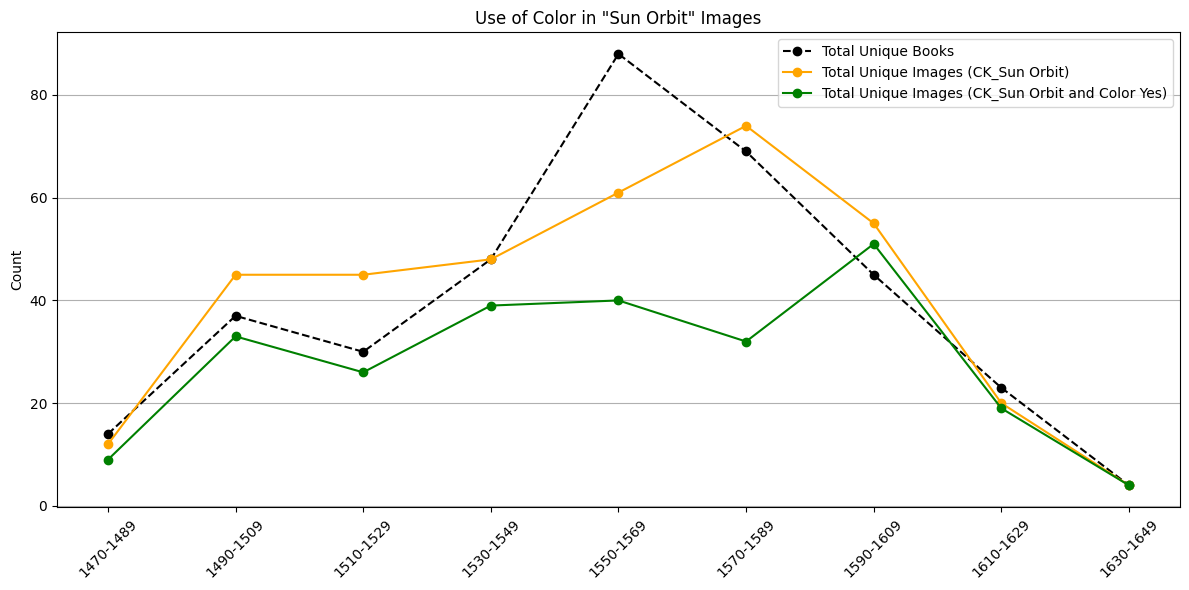

In [39]:
# Convert 'year' to int
natural_days_sun_motion['year'] = natural_days_sun_motion['year'].astype(int)
books['year'] = books['year'].astype(int)

# Create 20-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Create a new column for the 20-year intervals
natural_days_sun_motion['interval'] = pd.cut(natural_days_sun_motion['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Count total unique books per interval
total_unique_books_per_interval = books.groupby('interval', observed=False)['book'].nunique().reindex(labels, fill_value=0)

# Count total unique images with 'CK_Sun Orbit' per interval
unique_images_ck_sun_orbit = natural_days_sun_motion[natural_days_sun_motion['cks'].str.contains('CK_Sun Orbit', na=False)]
total_unique_images_ck_sun_orbit_per_interval = unique_images_ck_sun_orbit.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Count total unique images with 'CK_Sun Orbit' and 'color' as 'yes' per interval
unique_images_color_yes = unique_images_ck_sun_orbit[unique_images_ck_sun_orbit['color'] == 'yes']
total_unique_images_color_yes_per_interval = unique_images_color_yes.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Prepare data for plotting
summary_data = pd.DataFrame({
    'Interval': labels,
    'Total Unique Books': total_unique_books_per_interval,
    'Total Unique Images (CK_Sun Orbit)': total_unique_images_ck_sun_orbit_per_interval,
    'Total Unique Images (CK_Sun Orbit and Color Yes)': total_unique_images_color_yes_per_interval
})

# Create a line graph
plt.figure(figsize=(12, 6))
plt.plot(summary_data['Interval'], summary_data['Total Unique Books'], marker='o', linestyle='--', color='black', label='Total Unique Books')  # Broken black line
plt.plot(summary_data['Interval'], summary_data['Total Unique Images (CK_Sun Orbit)'], marker='o', linestyle='-', label='Total Unique Images (CK_Sun Orbit)', color='orange')
plt.plot(summary_data['Interval'], summary_data['Total Unique Images (CK_Sun Orbit and Color Yes)'], marker='o', linestyle='-', label='Total Unique Images (CK_Sun Orbit and Color Yes)', color='green')

# Formatting the plot
plt.ylabel('Count')
plt.title('Use of Color in "Sun Orbit" Images')
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


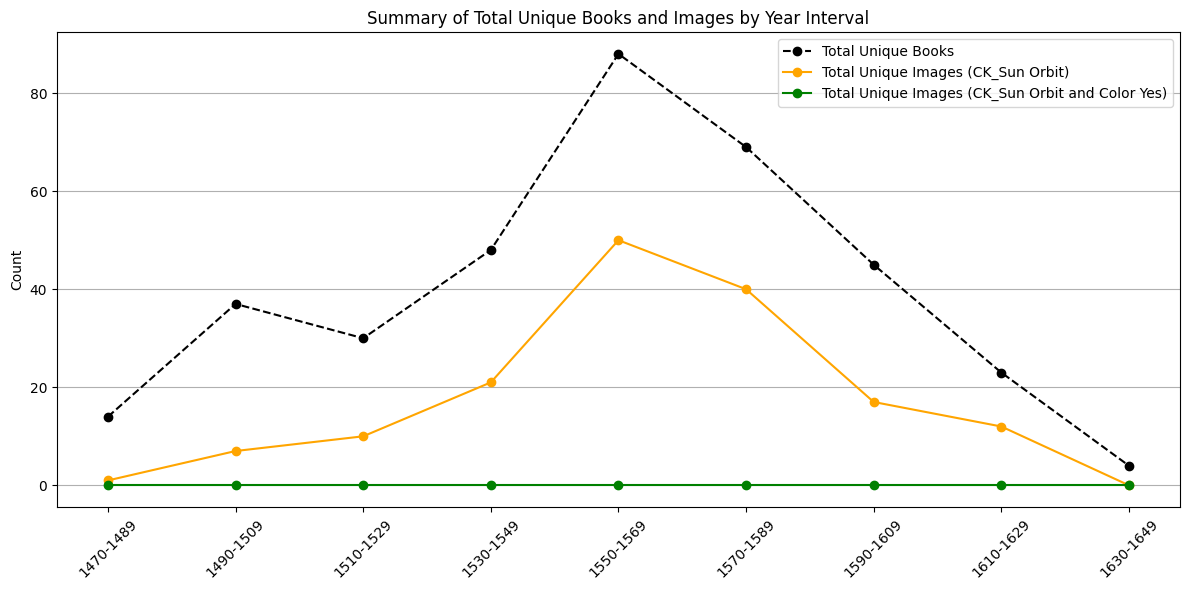

In [21]:
# Convert 'year' to int
rising_setting_poets_visual['year'] = rising_setting_poets_visual['year'].astype(int)
books['year'] = books['year'].astype(int)

# Create 20-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Create a new column for the 20-year intervals
rising_setting_poets_visual['interval'] = pd.cut(rising_setting_poets_visual['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Count total unique books per interval
total_unique_books_per_interval = books.groupby('interval', observed=False)['book'].nunique().reindex(labels, fill_value=0)

# Count total unique images with 'CK_Sun Orbit' per interval
unique_images_ck_sun_orbit = rising_setting_poets_visual[rising_setting_poets_visual['cks'].str.contains('CK_Inequality of Natural Days', na=False)]
total_unique_images_ck_sun_orbit_per_interval = unique_images_ck_sun_orbit.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Count total unique images with 'CK_Sun Orbit' and 'color' as 'yes' per interval
unique_images_color_yes = unique_images_ck_sun_orbit[unique_images_ck_sun_orbit['color'] == 'yes']
total_unique_images_color_yes_per_interval = unique_images_color_yes.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Prepare data for plotting
summary_data = pd.DataFrame({
    'Interval': labels,
    'Total Unique Books': total_unique_books_per_interval,
    'Total Unique Images (CK_Sun Orbit)': total_unique_images_ck_sun_orbit_per_interval,
    'Total Unique Images (CK_Sun Orbit and Color Yes)': total_unique_images_color_yes_per_interval
})

# Create a line graph
plt.figure(figsize=(12, 6))
plt.plot(summary_data['Interval'], summary_data['Total Unique Books'], marker='o', linestyle='--', color='black', label='Total Unique Books')  # Broken black line
plt.plot(summary_data['Interval'], summary_data['Total Unique Images (CK_Sun Orbit)'], marker='o', linestyle='-', label='Total Unique Images (CK_Sun Orbit)', color='orange')
plt.plot(summary_data['Interval'], summary_data['Total Unique Images (CK_Sun Orbit and Color Yes)'], marker='o', linestyle='-', label='Total Unique Images (CK_Sun Orbit and Color Yes)', color='green')

# Formatting the plot
plt.ylabel('Count')
plt.title('Summary of Total Unique Books and Images by Year Interval')
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


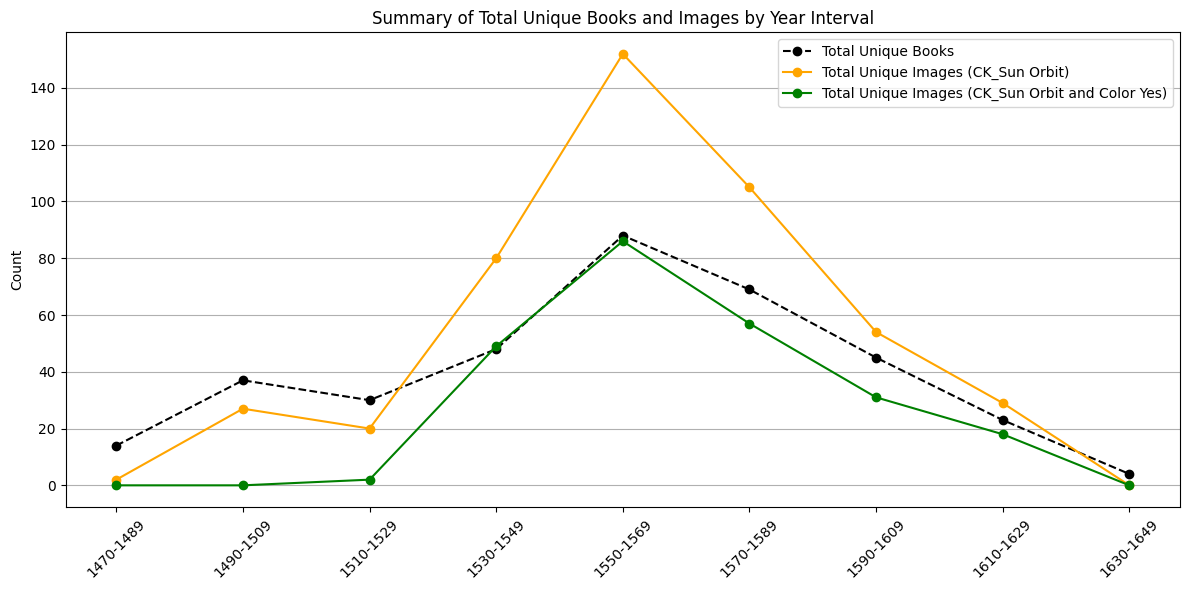

In [22]:


# Convert 'year' to int
rising_setting_poets_visual['year'] = rising_setting_poets_visual['year'].astype(int)
books['year'] = books['year'].astype(int)

# Create 20-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Create a new column for the 20-year intervals
rising_setting_poets_visual['interval'] = pd.cut(rising_setting_poets_visual['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Count total unique books per interval
total_unique_books_per_interval = books.groupby('interval', observed=False)['book'].nunique().reindex(labels, fill_value=0)

# Count total unique images with 'CK_Sun Orbit' per interval
unique_images_ck_sun_orbit = rising_setting_poets_visual[rising_setting_poets_visual['cks'].str.contains('CK_Circles of Natural Days', na=False)]
total_unique_images_ck_sun_orbit_per_interval = unique_images_ck_sun_orbit.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Count total unique images with 'CK_Sun Orbit' and 'color' as 'yes' per interval
unique_images_color_yes = unique_images_ck_sun_orbit[unique_images_ck_sun_orbit['color'] == 'yes']
total_unique_images_color_yes_per_interval = unique_images_color_yes.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Prepare data for plotting
summary_data = pd.DataFrame({
    'Interval': labels,
    'Total Unique Books': total_unique_books_per_interval,
    'Total Unique Images (CK_Sun Orbit)': total_unique_images_ck_sun_orbit_per_interval,
    'Total Unique Images (CK_Sun Orbit and Color Yes)': total_unique_images_color_yes_per_interval
})

# Create a line graph
plt.figure(figsize=(12, 6))
plt.plot(summary_data['Interval'], summary_data['Total Unique Books'], marker='o', linestyle='--', color='black', label='Total Unique Books')  # Broken black line
plt.plot(summary_data['Interval'], summary_data['Total Unique Images (CK_Sun Orbit)'], marker='o', linestyle='-', label='Total Unique Images (CK_Sun Orbit)', color='orange')
plt.plot(summary_data['Interval'], summary_data['Total Unique Images (CK_Sun Orbit and Color Yes)'], marker='o', linestyle='-', label='Total Unique Images (CK_Sun Orbit and Color Yes)', color='green')

# Formatting the plot
plt.ylabel('Count')
plt.title('Summary of Total Unique Books and Images by Year Interval')
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


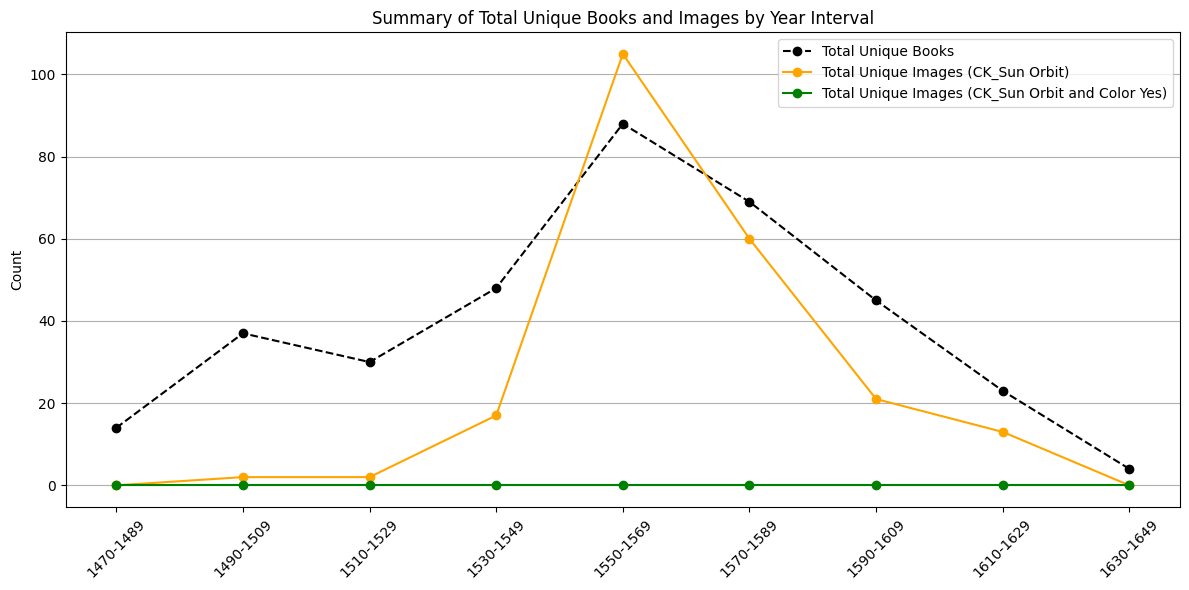

In [23]:


# Convert 'year' to int
rising_setting_poets_visual['year'] = rising_setting_poets_visual['year'].astype(int)
books['year'] = books['year'].astype(int)

# Create 20-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Create a new column for the 20-year intervals
rising_setting_poets_visual['interval'] = pd.cut(rising_setting_poets_visual['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Count total unique books per interval
total_unique_books_per_interval = books.groupby('interval', observed=False)['book'].nunique().reindex(labels, fill_value=0)

# Count total unique images with 'CK_Sun Orbit' per interval
unique_images_ck_sun_orbit = rising_setting_poets_visual[rising_setting_poets_visual['cks'].str.contains('CK_Movement of the Sun', na=False)]
total_unique_images_ck_sun_orbit_per_interval = unique_images_ck_sun_orbit.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Count total unique images with 'CK_Sun Orbit' and 'color' as 'yes' per interval
unique_images_color_yes = unique_images_ck_sun_orbit[unique_images_ck_sun_orbit['color'] == 'yes']
total_unique_images_color_yes_per_interval = unique_images_color_yes.groupby('interval', observed=False)['images'].nunique().reindex(labels, fill_value=0)

# Prepare data for plotting
summary_data = pd.DataFrame({
    'Interval': labels,
    'Total Unique Books': total_unique_books_per_interval,
    'Total Unique Images (CK_Sun Orbit)': total_unique_images_ck_sun_orbit_per_interval,
    'Total Unique Images (CK_Sun Orbit and Color Yes)': total_unique_images_color_yes_per_interval
})

# Create a line graph
plt.figure(figsize=(12, 6))
plt.plot(summary_data['Interval'], summary_data['Total Unique Books'], marker='o', linestyle='--', color='black', label='Total Unique Books')  # Broken black line
plt.plot(summary_data['Interval'], summary_data['Total Unique Images (CK_Sun Orbit)'], marker='o', linestyle='-', label='Total Unique Images (CK_Sun Orbit)', color='orange')
plt.plot(summary_data['Interval'], summary_data['Total Unique Images (CK_Sun Orbit and Color Yes)'], marker='o', linestyle='-', label='Total Unique Images (CK_Sun Orbit and Color Yes)', color='green')

# Formatting the plot
plt.ylabel('Count')
plt.title('Summary of Total Unique Books and Images by Year Interval')
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\nogas\AppData\Local\Temp\ipykernel_16376\2653386067.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_images_per_interval = filtered_df.groupby('interval')['images'].nunique().reset_index()
C:\Users\nogas\AppData\Local\Temp\ipykernel_16376\2653386067.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_images_per_interval = filtered_df.groupby('interval')['images'].nunique().reset_index()
C:\Users\nogas\AppData\Local\Temp\ipykernel_16376\2653386067.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observe

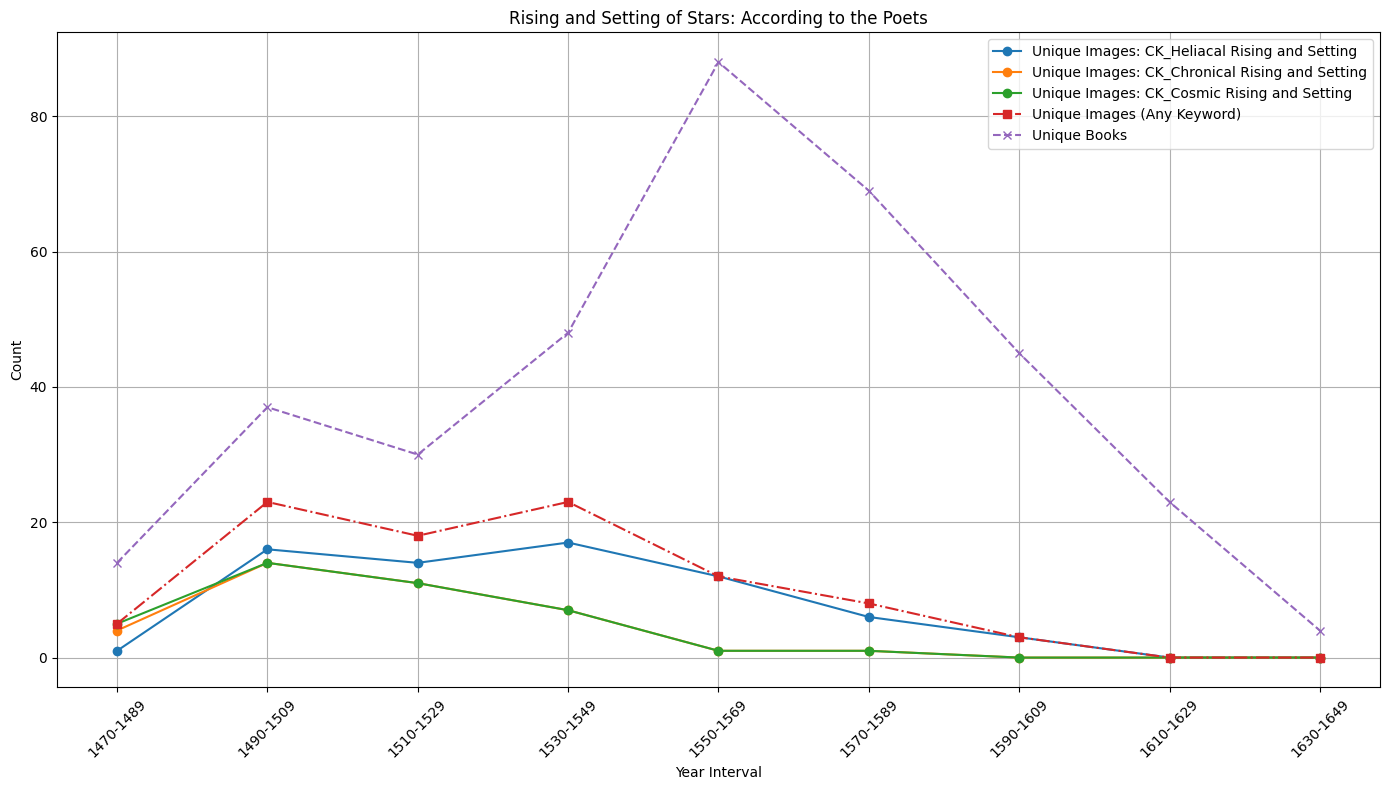

In [24]:
# Ensure the year column is of integer type
df['year'] = df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649'
]

# Add interval column to the DataFrames
df['interval'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Define keywords
keywords = [
    'CK_Heliacal Rising and Setting', 'CK_Chronical Rising and Setting', 'CK_Cosmic Rising and Setting'
]

# Prepare a DataFrame to hold unique counts for each keyword
keyword_dfs = {}
for keyword in keywords:
    mask = df['cks'].apply(lambda x: keyword in x)
    filtered_df = df[mask]
    unique_images_per_interval = filtered_df.groupby('interval')['images'].nunique().reset_index()
    unique_images_per_interval.columns = ['interval', f'unique_images_{keyword}']
    keyword_dfs[keyword] = unique_images_per_interval

# Create a single mask for all keywords for the combined count
combined_mask = df['cks'].apply(lambda x: any(keyword in x for keyword in keywords))
filtered_combined_df = df[combined_mask]
unique_images_combined = filtered_combined_df.groupby('interval')['images'].nunique().reset_index()
unique_images_combined.columns = ['interval', 'unique_images_any']

# Merge all keyword DataFrames on 'interval'
merged_keyword_df = keyword_dfs[keywords[0]]
for keyword in keywords[1:]:
    merged_keyword_df = pd.merge(merged_keyword_df, keyword_dfs[keyword], on='interval', how='outer')

# Merge the combined unique images DataFrame
final_df = pd.merge(merged_keyword_df, unique_images_combined, on='interval', how='outer')

# Count unique books per interval
unique_books_per_interval = books.groupby('interval')['book'].nunique().reset_index()
unique_books_per_interval.columns = ['interval', 'unique_books']
final_df = pd.merge(final_df, unique_books_per_interval, on='interval', how='outer')

# Plot the results
plt.figure(figsize=(14, 8))

# Plot each keyword's unique images
for keyword in keywords:
    plt.plot(final_df['interval'], final_df[f'unique_images_{keyword}'], label=f'Unique Images: {keyword}', marker='o')

# Plot total unique images with any of the keywords
plt.plot(final_df['interval'], final_df['unique_images_any'], label='Unique Images (Any Keyword)', marker='s', linestyle='-.')

# Plot unique books
plt.plot(final_df['interval'], final_df['unique_books'], label='Unique Books', marker='x', linestyle='--')

plt.xlabel('Year Interval')
plt.ylabel('Count')
plt.title('Rising and Setting of Stars: According to the Poets')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
